# Прогноз оттока клиентов

**Описание исследования**  

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Необходимо построить модель с предельно большим значением F1-меры (минимум 0.59), определить F1-меру на тестовой выборке, параллельно измерять AUC-ROC, сравнивая значение с F1-мерой.

**Цель исследования**
- Исследовать баланс классов, обучить модели несмотря на существующий дисбаланс
- Улучшить качество моделей, учитывая дисбаланс классов, найти лучшую
- Провести финальное тестирование

**Ход исследования**
- Обзор данных
- Предобработка данных
- Разбиение на тренировочную, валидационную и тестовую выборки
- Обучение моделей при различных условиях
- Проверка на тестовой выборке
- Общий вывод

## Импорт необходимых библиотек

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    mean_squared_error,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    make_scorer,
)
from scipy.stats import uniform, randint
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config

set_config(display="diagram")

from warnings import simplefilter

## Загрузка данных

In [65]:
try:
    df = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_6_supervised_learning\data\Churn.csv"
    )
except:
    df = pd.read_csv("/datasets/Churn.csv")

## Обзор данных

In [66]:
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2696,2697,15792176,Henty,698,Spain,Female,40,0.0,92053.44,1,1,1,143681.83,0
1187,1188,15719302,Brennan,765,France,Female,50,9.0,126547.80,1,1,1,79579.94,1
5496,5497,15642515,Arcuri,620,France,Female,42,1.0,0.00,2,0,1,65565.92,0
282,283,15643024,Huang,479,Germany,Male,35,4.0,138718.92,1,1,1,47251.79,1
3751,3752,15630106,Lo,496,Spain,Male,29,2.0,0.00,2,1,0,55389.59,0
7753,7754,15777616,Pisani,605,Germany,Male,28,10.0,113690.83,1,1,0,33114.24,0
7100,7101,15668830,Wan,650,Spain,Male,24,NaN,108881.73,1,1,0,104492.83,0
536,537,15592846,Fiorentini,639,Germany,Male,35,10.0,128173.90,2,1,0,59093.39,0
7702,7703,15719931,Johnstone,850,France,Male,31,8.0,0.00,2,1,0,178667.70,0
2368,2369,15769312,Forbes,557,Spain,Male,48,10.0,0.00,2,1,1,185094.48,0


**Вывод**   

Столбцы `row_number`, `customer_id` и `surname` обращают на себя внимание. Так, `customer_id` и `surname` это категориальные параметры, уникальные для каждой из строк, значит, при обучении моделей они не потребуются. `row_number` вовсе повторяет существующие индексы с увеличением номера на 1. Столбцы `geography` и `gender` потребуют кодирования. 

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод**   

В столбце `tenure` около тысячи пропусков, от которых хорошо было бы избавиться. Типы данных соответствуют содержимому столбцов. 

In [68]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод**   

Параметры имеют разные порядки, а значит может потребоваться масштабирования. Также вероятно наличие выбросов. К примеру, в столбце `estimated_salary` минимальным значением является 11.58, что не соответствует адекватным значениям зарплаты. 

In [69]:
df.duplicated().sum()

0

In [70]:
df["CustomerId"].duplicated().sum()

0

**Вывод**   

Явные дубликаты отсутсвуют. Судя по отсуствию повторов в столбце `customer_id`, неявных дубликатов тоже нет. 

In [71]:
df.corr(numeric_only=True)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


**Вывод**   

Сильная корреляция между параметрами не наблюдается

In [72]:
num_ft = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
    "Exited",
]

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

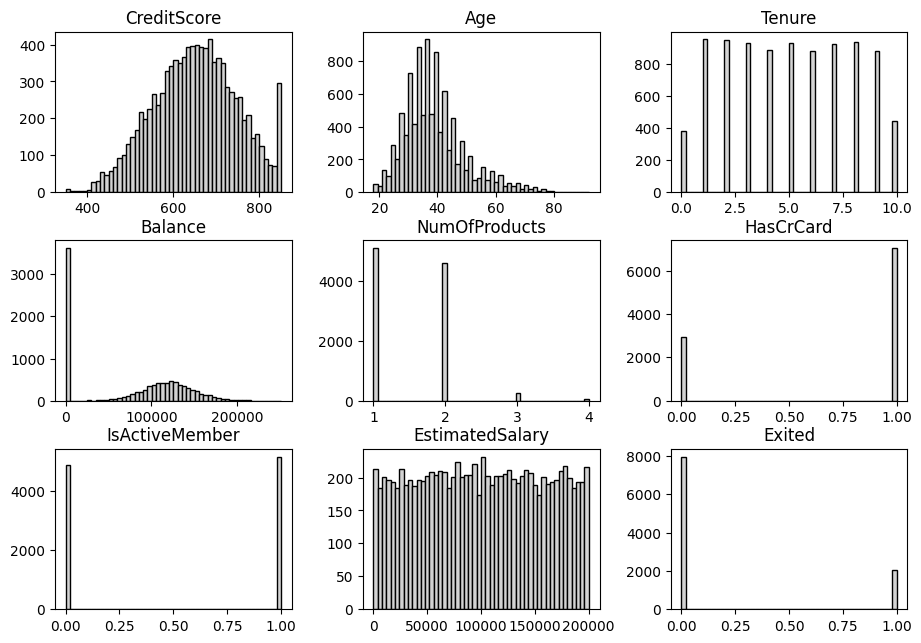

In [73]:
df[num_ft].hist(
    bins=50, figsize=(11, 7.5), edgecolor="black", color="lightgrey", grid=False
)

Итак, нам предстоит решить задачу бинарной классификации - предугадать, какие клиенты в ближайшее время покинут банк (столбец `exited`). Для этого будет производиться обучение моделей на основе следующих данных: 
- `credit_score` - Кредитный рейтинг
- `geography` - Страна проживания
- `gender` - Пол
- `age` - Возраст
- `tenure` - Сколько лет человек является клиентом
- `balance` - Баланс на счете
- `num_of_products` - Количество используемых продуктов
- `has_cr_card` - Наличие кредитки
- `is_active_member` - Активность клиента
- `estimated_salary` - Предполагаемая зарплата

Столбцы `row_number`, `customer_id`, `surname` будут удалены за ненадобностью. Столбец `tenure` требует дополнительной обработки из-за наличия пропусков в данных. 

Также стоит обратить внимание на дисбаланс между классами, где ушедших клиентов в представленном датасете примерно в 4 раза меньше, чем оставшихся.

## Предобработка данных

### Устранение первичных недостатков

В ходе обзора данных были выделены следующие явные недостатки: 
- Необходимо привести названия столбцов к змеиному регистру
- В столбце `tenure` присутствуют пропуски
- Столбцы `row_number`, `customer_id`, `surname` должны быть удалены

#### Названия столбцов

In [74]:
for i, column in enumerate(df.columns):
    df.rename(
        columns={
            df.columns[i]: "_".join(re.findall("[A-Z][^A-Z]*", df.columns[i])).lower()
        },
        inplace=True,
    )

In [75]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

#### Удаление лишних столбцов

In [76]:
df = df.drop(columns=["row_number", "customer_id", "surname"])

In [77]:
df.sample()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3453,619,Germany,Male,40,NaN,103604.31,2,0,0,140947.05,0


#### Заполнение пропусков

In [78]:
df["tenure"].value_counts()

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

Заполним пропуски в столбце `tenure` медианным значением (то есть 5)

In [79]:
# Здесь определим random_state, который будет использоваться во всем проекте
chosen_rand_st = 1992

In [80]:
# R = np.random.RandomState(chosen_rand_st)
# for country in df['geography'].unique():
#    random_tenures = pd.Series(
#        R.randint(0, 11, len(df[(df['tenure'].isna()) & (df['geography'] == country)])),
#        index=df[(df['geography'] == country) & (df['tenure'].isna())].index
#    ).astype('float64')
#    df.loc[(df['geography'] == country) & (df['tenure'].isna()), 'tenure'] = random_tenures
# df['tenure'].isna().sum()

In [81]:
df["tenure"].fillna(df[~df["tenure"].isna()]["tenure"].median(), inplace=True)

In [82]:
df["tenure"].value_counts()

tenure
5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: count, dtype: int64

### Функция для построения боксплотов

In [83]:
def boxplot_builder(column):
    plt.figure(figsize=(7, 3))
    plt.boxplot(
        x=df[column],
        notch=True,
        vert=False,
        patch_artist=True,
    )
    plt.title(f"{column} boxplot")
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR
    print(f"Нижняя граница равна {left_border}")
    print(f"Верхняя граница равна {right_border}")

### Обзор данных при помощи боксплотов

#### credit_score

Нижняя граница равна 383.0
Верхняя граница равна 919.0


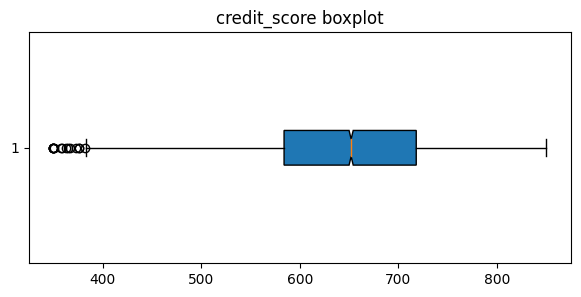

In [84]:
boxplot_builder("credit_score")

Посмотрим что за данные лежат левее нижней границы.

In [85]:
df[df["credit_score"] < 383]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
942,376,France,Female,46,5.0,0.00,1,1,0,157333.69,1
1193,363,Spain,Female,28,6.0,146098.43,3,1,0,100615.14,1
1405,359,France,Female,44,5.0,128747.69,1,1,0,146955.71,1
1631,350,Spain,Male,54,1.0,152677.48,1,1,1,191973.49,1
1838,350,Germany,Male,39,0.0,109733.20,2,0,0,123602.11,1
1962,358,Spain,Female,52,8.0,143542.36,3,1,0,141959.11,1
2473,351,Germany,Female,57,4.0,163146.46,1,1,0,169621.69,1
2579,365,Germany,Male,30,0.0,127760.07,1,1,0,81537.85,1
8154,367,Spain,Male,42,6.0,93608.28,1,1,0,168816.73,1


Всего 15 строк, но крайне ценных, посольку в каждой из них клиент ушел их банка. Оставляем. 

#### age

Нижняя граница равна 14.0
Верхняя граница равна 62.0


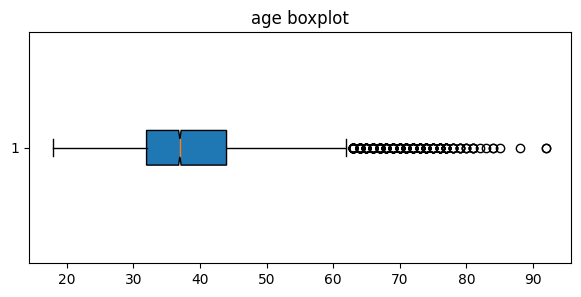

In [86]:
boxplot_builder("age")

Присутствуют выбросы. Посмотрим, сколько строк мы потеряем, если отрежем все возрасты старше 62 лет. 

In [87]:
df[df["age"] > 62]["age"].count()
perc = df[df["age"] > 62]["age"].count() * 100 / len(df["age"])
print(f"Percentage = {perc:.2f} %")

Percentage = 3.59 %


3.59 % - не критичная потеря. Уберем из датасета клиентов старше 62 лет.

In [88]:
df = df[df["age"] < 62]
len(df)

9589

#### balance

Нижняя граница равна -191492.535
Верхняя граница равна 319154.225


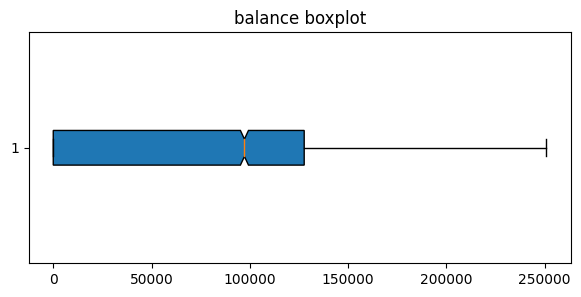

In [89]:
boxplot_builder("balance")

Выбросы отсутствуют.

#### estimated_salary

Нижняя граница равна -96122.29499999998
Верхняя граница равна 296807.345


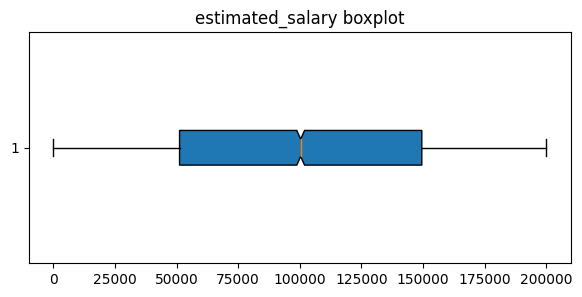

In [90]:
boxplot_builder("estimated_salary")

Выбросы отсутствуют. 

## Разбиение на выборки 

Разделим датафреймы на выборки в соотношении 3:1:1.

In [91]:
X = df.drop(columns="exited")
y = df["exited"]

In [92]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=chosen_rand_st, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=chosen_rand_st, stratify=y_temp
)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(5753, 10) (1918, 10) (1918, 10)
(5753,) (1918,) (1918,)


In [93]:
# проверка баланса тренировочной выборки
zeros = y_train[y_train == 0].count()
ones = y_train[y_train == 1].count()
print(zeros / ones)

# проверка баланса валидационной выборки
zeros_val = y_valid[y_valid == 0].count()
ones_val = y_valid[y_valid == 1].count()
print(zeros_val / ones_val)

# проверка баланса тестовой выборки
zeros_test = y_test[y_test == 0].count()
ones_test = y_test[y_test == 1].count()
print(zeros_test / ones_test)

3.938197424892704
3.930591259640103
3.930591259640103


## Пайплайны

In [94]:
cat_cols = ["geography", "gender", "num_of_products", "has_cr_card", "is_active_member"]
num_cols = ["credit_score", "age", "tenure", "balance", "estimated_salary"]

In [95]:
ohe_pipeline = ColumnTransformer([("ohe", OneHotEncoder(), cat_cols)])
oe_pipeline = ColumnTransformer([("oe", OrdinalEncoder(), cat_cols)])

In [96]:
# DTC OHE pipe
dtc_unscaled_pipeline = Pipeline(
    [("ohe", ohe_pipeline), ("dtc", DecisionTreeClassifier())]
)

# RFC OHE pipe
rfc_unscaled_pipeline = Pipeline(
    [("ohe", ohe_pipeline), ("rfc", RandomForestClassifier())]
)

# LR OHE pipe
lr_unscaled_pipeline = Pipeline([("ohe", ohe_pipeline), ("lr", LogisticRegression())])

ohe_unscaled_pipe_list = [
    dtc_unscaled_pipeline,
    rfc_unscaled_pipeline,
    lr_unscaled_pipeline,
]

In [97]:
# DTC OE pipe
dtc_unscaled_oe_pipeline = Pipeline(
    [("oe", oe_pipeline), ("dtc", DecisionTreeClassifier())]
)

# RFC OE pipe
rfc_unscaled_oe_pipeline = Pipeline(
    [("oe", oe_pipeline), ("rfc", RandomForestClassifier())]
)

# LR OE pipe
lr_unscaled_oe_pipeline = Pipeline([("oe", oe_pipeline), ("lr", LogisticRegression())])

oe_unscaled_pipe_list = [
    dtc_unscaled_oe_pipeline,
    rfc_unscaled_oe_pipeline,
    lr_unscaled_oe_pipeline,
]

In [98]:
unskaled_pipe_list = [ohe_unscaled_pipe_list, oe_unscaled_pipe_list]

In [99]:
scale_pipeline = Pipeline([("std_scaler", StandardScaler())])

ohe_sclaled_pipeline = ColumnTransformer(
    [("scale", scale_pipeline, num_cols), ("ohe", OneHotEncoder(), cat_cols)]
)

oe_scaled_pipeline = ColumnTransformer(
    [("scale", scale_pipeline, num_cols), ("oe", OrdinalEncoder(), cat_cols)]
)

In [100]:
# DTC OHE pipe scaled
dtc_pipeline = Pipeline(
    [("ohe", ohe_sclaled_pipeline), ("dtc", DecisionTreeClassifier())]
)

# RFC OHE pipe scaled
rfc_pipeline = Pipeline(
    [("ohe", ohe_sclaled_pipeline), ("rfc", RandomForestClassifier())]
)

# LR OHE pipe scaled
lr_pipeline = Pipeline([("ohe", ohe_sclaled_pipeline), ("lr", LogisticRegression())])

ohe_pipe_list = [dtc_pipeline, rfc_pipeline, lr_pipeline]

In [101]:
# DTC OE pipe scaled
dtc_oe_pipeline = Pipeline(
    [("oe", oe_scaled_pipeline), ("dtc", DecisionTreeClassifier())]
)

# RFC OE pipe scaled
rfc_oe_pipeline = Pipeline(
    [("oe", oe_scaled_pipeline), ("rfc", RandomForestClassifier())]
)

# LR OE pipe scaled
lr_oe_pipeline = Pipeline([("oe", oe_scaled_pipeline), ("lr", LogisticRegression())])

oe_pipe_list = [dtc_oe_pipeline, rfc_oe_pipeline, lr_oe_pipeline]

In [102]:
pipe_list = [ohe_pipe_list, oe_pipe_list]

## Функция для обучения моделей

In [103]:
def model_learn(mod, data_list, score_list, name_list=None, encoder_names=None):
    model = mod.fit(data_list[0], data_list[1])
    predictions = model.predict(data_list[2])
    f1 = f1_score(data_list[3], predictions)

    probabilities = model.predict_proba(data_list[2])
    probabilities_one = probabilities[:, 1]

    auc_roc = roc_auc_score(data_list[3], probabilities_one)

    accuracy = accuracy_score(data_list[3], predictions)
    print("-" * 79)
    if name_list is not None:
        print(f"Результат лучшей модели {name_list}:\n")
        print(
            f"\nF1 = {f1:.3f} | AUC-ROC = {auc_roc:.3f} | Accuracy = {accuracy:.3f}\n"
        )
    if encoder_names is not None:
        print(f"Encoder: {encoder_names}\n")
    print(f"Гипер-параметры: {model.best_params_}")

    score_list.append([f1, auc_roc, accuracy])

    print("-" * 79)
    print()

In [104]:
model_names = ["DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression"]
encoder_names = ["OHE", "OE"]

## Работа с моделями

В переменную class_weight записывается желаемый тип взвешивания классов: `None`, если вес каждого класса должен быть равен 1, `'balanced'`, если вес каждого класса должен иметь оптимальный вес.  

In [105]:
data_list = [X_train, y_train, X_valid, y_valid]

### Масштабирование параметров

In [106]:
class_weight = None

In [107]:
dtc_param_grid = [
    {
        "dtc__max_depth": np.arange(4, 20, 4),
        "dtc__min_samples_split": np.arange(2, 10, 2),
        "dtc__min_samples_leaf": np.arange(1, 10, 1),
        "dtc__class_weight": [class_weight],
        "dtc__max_features": [1, "sqrt", "log2", None],
        "dtc__splitter": ["best", "random"],
        "dtc__random_state": [chosen_rand_st],
    }
]

rfc_param_grid = [
    {
        "rfc__n_estimators": np.arange(40, 201, 40),
        "rfc__max_depth": np.arange(4, 21, 4),
        "rfc__class_weight": [class_weight],
        "rfc__max_features": [1, "sqrt", "log2", None],
        "rfc__random_state": [chosen_rand_st],
    }
]

lr_param_grid = [
    {
        "lr__solver": ["liblinear"],
        "lr__max_iter": [100, 250, 500, 1000, 2000],
        "lr__tol": [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
        "lr__class_weight": [class_weight],
        "lr__C": [0.01, 0.1, 1.0, 10, 100],
        "lr__random_state": [chosen_rand_st],
    }
]

param_grid_list = [dtc_param_grid, rfc_param_grid, lr_param_grid]

#### Без масштабирования

In [108]:
%%time
unscaled_score = []
for e, pipe in enumerate(unskaled_pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            param_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )
        model_learn(
            grid_pipeline, data_list, 
            unscaled_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.433 | AUC-ROC = 0.780 | Accuracy = 0.821

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': None, 'dtc__max_depth': 4, 'dtc__max_features': None, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'best'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.433 | AUC-ROC = 0.777 | Accuracy = 0.821

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': None, 'rfc__max_depth': 4, 'rfc__max_features': None, 'rfc__n_estimators': 40, 'rfc__random_state': 1992}
----------------------------------------------------------

#### С масштабированием

In [109]:
%%time
unweighed_score = []
for e, pipe in enumerate(pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            param_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        model_learn(
            grid_pipeline, data_list, 
            unweighed_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.549 | AUC-ROC = 0.812 | Accuracy = 0.847

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': None, 'dtc__max_depth': 16, 'dtc__max_features': None, 'dtc__min_samples_leaf': 7, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'random'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.576 | AUC-ROC = 0.851 | Accuracy = 0.857

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': None, 'rfc__max_depth': 16, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 40, 'rfc__random_state': 1992}
----------------------------------------------------

#### Результат масштабирования

In [110]:
unscaled_score_df = pd.DataFrame(
    unscaled_score,
    columns=["f1_unscaled", "auc_roc_unscaled", "accuracy_unscaled"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()
unweighed_score_df = pd.DataFrame(
    unweighed_score,
    columns=["f1_unweighed", "auc_roc_unweighed", "accuracy_unweighed"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()

total_scaling_score = pd.concat([unscaled_score_df, unweighed_score_df], axis=0)

In [111]:
total_scaling_score.loc[["f1_unscaled", "f1_unweighed"], :].style.highlight_max(
    color="lightgreen", axis=0
).highlight_min(color="mistyrose", axis=0)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
f1_unscaled,0.433058,0.433058,0.371058,0.433058,0.433058,0.000000
f1_unweighed,0.549080,0.576271,0.587500,0.569678,0.564593,0.419183


In [112]:
total_scaling_score.loc[
    ["auc_roc_unscaled", "auc_roc_unweighed"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
auc_roc_unscaled,0.779625,0.777442,0.783167,0.781366,0.780460,0.616716
auc_roc_unweighed,0.811775,0.850643,0.854889,0.791811,0.856540,0.780889


In [113]:
total_scaling_score.loc[
    ["accuracy_unscaled", "accuracy_unweighed"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
accuracy_unscaled,0.821168,0.821168,0.823253,0.821168,0.821168,0.797185
accuracy_unweighed,0.846715,0.856621,0.862357,0.853493,0.857664,0.829510


**Вывод:** масштабирование улучшило результаты во всех случаях

### Взвешивание классов

In [114]:
class_weight = "balanced"

In [115]:
dtc_param_grid = [
    {
        "dtc__max_depth": np.arange(4, 20, 4),
        "dtc__min_samples_split": np.arange(2, 10, 2),
        "dtc__min_samples_leaf": np.arange(1, 10, 1),
        "dtc__class_weight": [class_weight],
        "dtc__max_features": [1, "sqrt", "log2", None],
        "dtc__splitter": ["best", "random"],
        "dtc__random_state": [chosen_rand_st],
    }
]

rfc_param_grid = [
    {
        "rfc__n_estimators": np.arange(40, 201, 40),
        "rfc__max_depth": np.arange(4, 21, 4),
        "rfc__class_weight": [class_weight],
        "rfc__max_features": [1, "sqrt", "log2", None],
        "rfc__random_state": [chosen_rand_st],
    }
]

lr_param_grid = [
    {
        "lr__solver": ["liblinear"],
        "lr__max_iter": [100, 250, 500, 1000, 2000],
        "lr__tol": [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
        "lr__class_weight": [class_weight],
        "lr__C": [0.01, 0.1, 1.0, 10, 100],
        "lr__random_state": [chosen_rand_st],
    }
]

weighed_grid_list = [dtc_param_grid, rfc_param_grid, lr_param_grid]

In [116]:
%%time
weighed_score = []
for e, pipe in enumerate(pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            weighed_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        model_learn(
            grid_pipeline, data_list, 
            weighed_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.563 | AUC-ROC = 0.843 | Accuracy = 0.765

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': 'balanced', 'dtc__max_depth': 8, 'dtc__max_features': None, 'dtc__min_samples_leaf': 6, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'random'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.606 | AUC-ROC = 0.857 | Accuracy = 0.814

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': 'balanced', 'rfc__max_depth': 8, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 120, 'rfc__random_state': 1992}
-----------------------------------------

#### Результат взвешивания классов

In [117]:
unweighed_score_df = pd.DataFrame(
    unweighed_score,
    columns=["f1_unweighed", "auc_roc_unweighed", "accuracy_unweighed"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()
weighed_score_df = pd.DataFrame(
    weighed_score,
    columns=["f1_weighed", "auc_roc_weighed", "accuracy_weighed"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()

total_weighing_score = pd.concat([unweighed_score_df, weighed_score_df], axis=0)

In [118]:
total_weighing_score.loc[["f1_unweighed", "f1_weighed"], :].style.highlight_max(
    color="lightgreen", axis=0
).highlight_min(color="mistyrose", axis=0)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
f1_unweighed,0.549080,0.576271,0.587500,0.569678,0.564593,0.419183
f1_weighed,0.562561,0.605525,0.571429,0.581818,0.600675,0.506964


In [119]:
total_weighing_score.loc[
    ["auc_roc_unweighed", "auc_roc_weighed"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
auc_roc_unweighed,0.811775,0.850643,0.854889,0.791811,0.856540,0.780889
auc_roc_weighed,0.842930,0.857393,0.854177,0.825459,0.856544,0.782823


In [120]:
total_weighing_score.loc[
    ["accuracy_unweighed", "accuracy_weighed"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
accuracy_unweighed,0.846715,0.856621,0.862357,0.853493,0.857664,0.829510
accuracy_weighed,0.764859,0.813869,0.770073,0.808133,0.814911,0.723149


**Вывод:** взвешивание классов позитивно сказалось на F1-метрике во всех случаях, кроме логистической регрессии при OHE-кодировании. Колебания AUC-ROC незначительны, точность упала на 5-10%. 

Дальнейшие итерации обучения будем проводить с взвешенными классами.

### Ап/даунсемплинг 

#### Апсемплинг тренировочных выборок

In [121]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=chosen_rand_st
    )

    return X_upsampled, y_upsampled

Поскольку в исходном датасете позитивных ответов в примерно 4 раза меньше, чем негативных, число повторов установим равным 4. 

In [122]:
X_train_upsample, y_train_upsample = upsample(X_train, y_train, 4)
X_train.shape, y_train.shape, X_train_upsample.shape, y_train_upsample.shape

((5753, 10), (5753,), (9248, 10), (9248,))

In [123]:
# проверка баланса

zeros = y_train[y_train == 0].count()
ones = y_train[y_train == 1].count()
zeros_upsample = y_train_upsample[y_train_upsample == 0].count()
ones_upsample = y_train_upsample[y_train_upsample == 1].count()
print(zeros / ones, zeros_upsample / ones_upsample)

3.938197424892704 0.984549356223176


+- сбалансированно

In [124]:
data_upsample_list = [X_train_upsample, y_train_upsample, X_valid, y_valid]

#### Обучение на выборках после апсемплинга

In [125]:
class_weight = "balanced"

In [126]:
dtc_param_grid = [
    {
        "dtc__max_depth": np.arange(4, 20, 4),
        "dtc__min_samples_split": np.arange(2, 10, 2),
        "dtc__min_samples_leaf": np.arange(1, 10, 1),
        "dtc__class_weight": [class_weight],
        "dtc__max_features": [1, "sqrt", "log2", None],
        "dtc__splitter": ["best", "random"],
        "dtc__random_state": [chosen_rand_st],
    }
]

rfc_param_grid = [
    {
        "rfc__n_estimators": np.arange(40, 201, 40),
        "rfc__max_depth": np.arange(4, 21, 4),
        "rfc__class_weight": [class_weight],
        "rfc__max_features": [1, "sqrt", "log2", None],
        "rfc__random_state": [chosen_rand_st],
    }
]

lr_param_grid = [
    {
        "lr__solver": ["liblinear"],
        "lr__max_iter": [100, 250, 500, 1000, 2000],
        "lr__tol": [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
        "lr__class_weight": [class_weight],
        "lr__C": [0.01, 0.1, 1.0, 10, 100],
        "lr__random_state": [chosen_rand_st],
    }
]

weighed_grid_list = [dtc_param_grid, rfc_param_grid, lr_param_grid]

In [127]:
%%time
upsample_score = []
for e, pipe in enumerate(pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            weighed_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        model_learn(
            grid_pipeline, data_upsample_list, 
            upsample_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.482 | AUC-ROC = 0.685 | Accuracy = 0.774

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': 'balanced', 'dtc__max_depth': 16, 'dtc__max_features': 'sqrt', 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'best'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.586 | AUC-ROC = 0.844 | Accuracy = 0.845

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': 'balanced', 'rfc__max_depth': 20, 'rfc__max_features': 1, 'rfc__n_estimators': 120, 'rfc__random_state': 1992}
--------------------------------------------

#### Даунсемплинг тренировочных выборок

In [128]:
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=chosen_rand_st)] + [X_ones]
    )
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=chosen_rand_st)] + [y_ones]
    )

    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=chosen_rand_st
    )

    return X_downsampled, y_downsampled

In [129]:
X_train_downsample, y_train_downsample = downsample(X_train, y_train, 0.25)
X_train.shape, y_train.shape, X_train_downsample.shape, y_train_downsample.shape

((5753, 10), (5753,), (2312, 10), (2312,))

In [130]:
# проверка баланса

zeros = y_train[y_train == 0].count()
ones = y_train[y_train == 1].count()
zeros_downsample = y_train_downsample[y_train_downsample == 0].count()
ones_downsample = y_train_downsample[y_train_downsample == 1].count()
print(zeros / ones, zeros_downsample / ones_downsample)

3.938197424892704 0.984549356223176


+- сбалансированно

In [131]:
data_downsample_list = [X_train_downsample, y_train_downsample, X_valid, y_valid]

#### Обучение на выборках после даунсемплинга

In [132]:
%%time
downsample_score = []
for e, pipe in enumerate(pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            weighed_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        model_learn(
            grid_pipeline, data_downsample_list, 
            downsample_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.570 | AUC-ROC = 0.834 | Accuracy = 0.768

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': 'balanced', 'dtc__max_depth': 4, 'dtc__max_features': None, 'dtc__min_samples_leaf': 8, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'best'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.583 | AUC-ROC = 0.863 | Accuracy = 0.782

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': 'balanced', 'rfc__max_depth': 8, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 160, 'rfc__random_state': 1992}
-------------------------------------------

#### Результат ап/даунсемплинга

In [133]:
upsample_score_df = pd.DataFrame(
    upsample_score,
    columns=["f1_upsample", "auc_roc_upsample", "accuracy_upsample"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()
downsmaple_score_df = pd.DataFrame(
    downsample_score,
    columns=["f1_downsmaple", "auc_roc_downsmaple", "accuracy_downsmaple"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()

total_sampling_score = pd.concat([upsample_score_df, downsmaple_score_df], axis=0)
temp_summary = pd.concat([total_weighing_score, total_sampling_score], axis=0)

In [137]:
temp_summary.loc[
    ["f1_unweighed", "f1_weighed", "f1_upsample", "f1_downsmaple"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
f1_unweighed,0.549080,0.576271,0.587500,0.569678,0.564593,0.419183
f1_weighed,0.562561,0.605525,0.571429,0.581818,0.600675,0.506964
f1_upsample,0.482100,0.585774,0.571429,0.505689,0.594901,0.514392
f1_downsmaple,0.570048,0.582834,0.584555,0.548980,0.575024,0.512821


In [138]:
temp_summary.loc[
    ["auc_roc_unweighed", "auc_roc_weighed", "auc_roc_upsample", "auc_roc_downsmaple"],
    :,
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
auc_roc_unweighed,0.811775,0.850643,0.854889,0.791811,0.856540,0.780889
auc_roc_weighed,0.842930,0.857393,0.854177,0.825459,0.856544,0.782823
auc_roc_upsample,0.684570,0.844186,0.854180,0.692797,0.846252,0.783103
auc_roc_downsmaple,0.834359,0.863166,0.854923,0.826787,0.845782,0.781562


In [139]:
temp_summary.loc[
    [
        "accuracy_unweighed",
        "accuracy_weighed",
        "accuracy_upsample",
        "accuracy_downsmaple",
    ],
    :,
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
accuracy_unweighed,0.846715,0.856621,0.862357,0.853493,0.857664,0.829510
accuracy_weighed,0.764859,0.813869,0.770073,0.808133,0.814911,0.723149
accuracy_upsample,0.773723,0.845151,0.770073,0.796142,0.850886,0.727320
accuracy_downsmaple,0.767987,0.782065,0.778415,0.769552,0.771116,0.722628


**Вывод:** даунсемплинг позволил дереву решений получить лучшую метрику F1 при OHE-кодировании, что является лучшим результатом дерева решений на данный момент. В остальных случаях ап/даунсемплинг не дал явных положительных изменений. 

### Изменение порога классификации

Необходимо посмотреть, какие значения метрики F1 дадут модели при изменении порога классификации на своих самых "удобных" выборках. Для этого немного модифицируем функцию model_learn.

In [140]:
def model_thresholding_abuse(
    mod, data_list, score_list, name_list=None, encoder_names=None
):
    model = mod.fit(data_list[0], data_list[1])
    predictions = model.predict(data_list[2])

    probabilities = model.predict_proba(data_list[2])
    probabilities_one = probabilities[:, 1]

    auc_roc = roc_auc_score(data_list[3], probabilities_one)

    accuracy = accuracy_score(data_list[3], predictions)

    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0, 1, 0.01):
        predictions = probabilities_one > threshold
        f1 = f1_score(data_list[3], predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print("-" * 79)
    if name_list is not None:
        print(f"Результат лучшей модели {name_list}:\n")
        print(
            f"\nF1 = {best_f1:.3f} | AUC-ROC = {auc_roc:.3f} | Accuracy = {accuracy:.3f}\n"
        )
        print(f"Значение порога: {best_threshold}\n")
    if encoder_names is not None:
        print(f"Encoder: {encoder_names}\n")
    print(f"Гипер-параметры: {model.best_params_}")

    score_list.append([best_f1, auc_roc, accuracy])

    print("-" * 79)
    print()

In [141]:
special_data_list = [data_downsample_list, data_list, data_list]

In [142]:
%%time
thresholde_score = []
for e, pipe in enumerate(pipe_list):
    for i in range(0, 3):
        grid_pipeline = GridSearchCV(
            pipe[i], 
            weighed_grid_list[i], 
            cv=5, 
            scoring='f1', 
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        model_thresholding_abuse(
            grid_pipeline, special_data_list[i], 
            thresholde_score, model_names[i], encoder_names[e]
        )

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
-------------------------------------------------------------------------------
Результат лучшей модели DecisionTreeClassifier:


F1 = 0.595 | AUC-ROC = 0.834 | Accuracy = 0.768

Значение порога: 0.61

Encoder: OHE

Гипер-параметры: {'dtc__class_weight': 'balanced', 'dtc__max_depth': 4, 'dtc__max_features': None, 'dtc__min_samples_leaf': 8, 'dtc__min_samples_split': 2, 'dtc__random_state': 1992, 'dtc__splitter': 'best'}
-------------------------------------------------------------------------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-------------------------------------------------------------------------------
Результат лучшей модели RandomForestClassifier:


F1 = 0.622 | AUC-ROC = 0.857 | Accuracy = 0.814

Значение порога: 0.53

Encoder: OHE

Гипер-параметры: {'rfc__class_weight': 'balanced', 'rfc__max_depth': 8, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 120, 'rfc__random_state': 199

In [143]:
threshold_score_df = pd.DataFrame(
    thresholde_score,
    columns=["f1_threshold", "auc_roc_threshold", "accuracy_threshold"],
    index=["dtc_ohe", "rfc_ohe", "lr_ohe", "dtc_oe", "rfc_oe", "lr_oe"],
).transpose()

In [144]:
threshold_score_df.style.highlight_max(color="lightgreen", axis=1).highlight_min(
    color="mistyrose", axis=1
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
f1_threshold,0.594595,0.621908,0.624837,0.596010,0.616188,0.539894
auc_roc_threshold,0.834359,0.857393,0.854177,0.826787,0.856544,0.782823
accuracy_threshold,0.767987,0.813869,0.770073,0.769552,0.814911,0.723149


**Вывод:** благодаря изменению порога классификации все модели преодолели уровень метрики F1 = 0.59, за исключением логистической регрессии при OE-кодировании, что нормально, поскольку OE-кодирование мало применимо в случае логистической регрессии. Лучший показатель F1 = 0.64 имеет случайный лес. 

### Финальные тестирование

Финальное тестирование подразумевает проверку лучшей модели на тестовых выборках. В нашем случае это RandomForestClassifier с OHE-кодировщиком на выборке без ап/даунсемплинга.  
Гипер-параметры лучшей модели: `'rfc__class_weight': 'balanced', 'rfc__max_depth': 8, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 200, 'rfc__random_state': 1992`

In [145]:
data_list_test = [X_train, y_train, X_test, y_test]

In [146]:
best_rfc_pipeline = Pipeline(
    [
        ("ohe", ohe_sclaled_pipeline),
        (
            "rfc",
            RandomForestClassifier(
                class_weight="balanced",
                max_depth=8,
                max_features="sqrt",
                n_estimators=200,
                random_state=chosen_rand_st,
            ),
        ),
    ]
)
model = best_rfc_pipeline.fit(data_list_test[0], data_list_test[1])
predictions = model.predict(data_list_test[2])

probabilities = model.predict_proba(data_list_test[2])
probabilities_one = probabilities[:, 1]

auc_roc = roc_auc_score(data_list_test[3], probabilities_one)

accuracy = accuracy_score(data_list_test[3], predictions)

f1 = f1_score(data_list_test[3], predictions)

print("-" * 79)
print(f"Результат лучшей модели на тестовой выборке:\n")
print(f"F1 = {f1:.3f} | AUC-ROC = {auc_roc:.3f} | Accuracy = {accuracy:.3f}\n")
print(f"Encoder: {encoder_names[0]}\n")
print("-" * 79)

-------------------------------------------------------------------------------
Результат лучшей модели на тестовой выборке:

F1 = 0.607 | AUC-ROC = 0.861 | Accuracy = 0.818

Encoder: OHE

-------------------------------------------------------------------------------


**Вывод:** случайный лес подтвердил показатель F1 > 0.59 на тестовой выборке. 

### Проверка на вменяемость

Сравним лучшие модели с dummy-моделью, обученной на соответствующих данных

In [147]:
dummy_pipeline = Pipeline(
    [("ohe", ohe_sclaled_pipeline), ("rfc", DummyClassifier(strategy="most_frequent"))]
)

dummy_pipeline.fit(X_train, y_train)
dummy_predictions = dummy_pipeline.predict(X_test)

f1_dummy = f1_score(y_test, dummy_predictions)
accuracy_dummy = dummy_pipeline.score(X_test, y_test)

probabilities = dummy_pipeline.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
auc_roc_dummy = roc_auc_score(y_test, probabilities_one)
print("Метрики dummy-модели при OHE-кодировании")
print(
    f"F1 = {f1_dummy:.3f} | Accuracy = {accuracy_dummy:.3f} | AUC-ROC = {auc_roc_dummy:.3f}"
)

Метрики dummy-модели при OHE-кодировании
F1 = 0.000 | Accuracy = 0.797 | AUC-ROC = 0.500


Проверка пройдена (но вот ту я не уверен, должно ли быть F1 = 0)

### Общие результаты

Соберем все результаты в одну таблицу: 

In [148]:
total_sampling_score = pd.concat([upsample_score_df, downsmaple_score_df], axis=0)
temp_summary = pd.concat([total_weighing_score, total_sampling_score], axis=0)

In [149]:
final_summary = pd.concat([temp_summary, threshold_score_df], axis=0)

## Заключение

In [150]:
final_summary.loc[
    ["f1_unweighed", "f1_weighed", "f1_upsample", "f1_downsmaple", "f1_threshold"], :
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
f1_unweighed,0.549080,0.576271,0.587500,0.569678,0.564593,0.419183
f1_weighed,0.562561,0.605525,0.571429,0.581818,0.600675,0.506964
f1_upsample,0.482100,0.585774,0.571429,0.505689,0.594901,0.514392
f1_downsmaple,0.570048,0.582834,0.584555,0.548980,0.575024,0.512821
f1_threshold,0.594595,0.621908,0.624837,0.596010,0.616188,0.539894


In [151]:
final_summary.loc[
    [
        "auc_roc_unweighed",
        "auc_roc_weighed",
        "auc_roc_upsample",
        "auc_roc_downsmaple",
        "auc_roc_threshold",
    ],
    :,
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
auc_roc_unweighed,0.811775,0.850643,0.854889,0.791811,0.856540,0.780889
auc_roc_weighed,0.842930,0.857393,0.854177,0.825459,0.856544,0.782823
auc_roc_upsample,0.684570,0.844186,0.854180,0.692797,0.846252,0.783103
auc_roc_downsmaple,0.834359,0.863166,0.854923,0.826787,0.845782,0.781562
auc_roc_threshold,0.834359,0.857393,0.854177,0.826787,0.856544,0.782823


In [152]:
final_summary.loc[
    [
        "accuracy_unweighed",
        "accuracy_weighed",
        "accuracy_upsample",
        "accuracy_downsmaple",
        "accuracy_threshold",
    ],
    :,
].style.highlight_max(color="lightgreen", axis=0).highlight_min(
    color="mistyrose", axis=0
)

,dtc_ohe,rfc_ohe,lr_ohe,dtc_oe,rfc_oe,lr_oe
accuracy_unweighed,0.846715,0.856621,0.862357,0.853493,0.857664,0.829510
accuracy_weighed,0.764859,0.813869,0.770073,0.808133,0.814911,0.723149
accuracy_upsample,0.773723,0.845151,0.770073,0.796142,0.850886,0.727320
accuracy_downsmaple,0.767987,0.782065,0.778415,0.769552,0.771116,0.722628
accuracy_threshold,0.767987,0.813869,0.770073,0.769552,0.814911,0.723149


В результате оптимизации гипер-параметров и применения различных техник обработки параметров, были определены оптимальные условия для получения наибольшей F1-метрики: 
- Взвешивание классов позволило улучшить показатели
- Ап/даунсемплинг оказался бессмысленен во всех случаях, кроме дерева решений при OHE-кодировании
- Изменение порога классификации позволяет получить метрику F1 > 0.59 для всех моделей, кроме логистической регрессии при OE-кодировании